# Training a 4-wheel Robot to Respond to Hand Gestures using PCA and kmeans Clustering
By John Kostas

## This projects consists of three parts. Only the first two will be represented in this document, so please refer to the Github link for more information on the ESP32 and Jetson Nano programs. https://github.com/Bobaswett/Robot-Hand-Gestures
### Data Collection
I first took pictures for the three hand gestures the robot will be trained to respond to. I started with lots of variety in the backgrounds, people signaling, and distance to the camera, but it was more difficult to pinpoint the number of principal components in PCA when utilizing this technique. To better demonstrate some of the algorithms learned in this class I elected to keep the person signaling, the background, and the signaler's clothing consistent, and decided to only vary the hand gestures by distance from the camera. If I were to implement this algorithm again, I would ideally have used a supervised algorithm and used more data with more variability. 

### Model Training
This will consist of PCA, during which I will reduce the images to their 2 primary principal components, and Kmeans clustering, where I will separate the data. I will then use a confusion matrix with the labels of the data to confirm the accuracy. Of the model training.

### Base Robot Actuator Program
I will use an ESP32 module along with 4 motors to program a basic robot that can turn left, right, forward, and backward. I first tested this using a gaming controller with a library that helps to connect to the ESP32 bluetooth. Later, I will use a UART connection rather than bluetooth for connecting the device performing the algorithm to the ESP32 module.

### Jetson Nano Algorithm/Interface with Actuator Module
I will program a Jetson Nano to run the machine learning model explained in this document. I will use the library OpenCV to capture videos that will allow a frame-by-frame analysis of any hand gestures in front of the robot. The Jetson Nano will categorize the handgesture, then send a signal to the Jetson Nano telling it when to move after a certain confidence threshold has been reached. 

Import Necessary Libraries

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from PIL import Image
import os
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

Given that I created this data and already performed when separating the different gestures, I will jump right into preprocessing the images. I need to reduce the size of the images and change the formatting to numpy arrays.

In [34]:
def preprocess_images(input_folder, output_folder, size=(128, 128)):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith(".jpg"):
            img = Image.open(os.path.join(input_folder, filename))
            img = img.resize(size)
            img_normalized = np.array(img) / 255.0
            img_flattened = img_normalized.flatten()
            np.save(os.path.join(output_folder, filename.replace('.jpg', '.npy')), img_flattened)

preprocess_images('left', 'left_processed')
preprocess_images('right', 'right_processed')
preprocess_images('back', 'back_processed')

I will load all the preprocessed files into one dataset.

In [36]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".npy"):
            img = np.load(os.path.join(folder, filename))
            images.append(img)
    return np.array(images)

# Load the preprocessed images
left_images = load_images_from_folder('left_processed')
right_images = load_images_from_folder('right_processed')
back_images = load_images_from_folder('back_processed')

# Combine all images into a single dataset
X = np.concatenate((left_images, right_images, back_images), axis=0)

The first step is PCA. I will reduce the amount of principal components to 2, then visualize the data to see if there is adequate separation.

In [54]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
print(X_pca)

[[ -0.76043737   7.5812024 ]
 [  7.27428163  12.28719149]
 [  5.99269232  12.37393789]
 [ 13.93119776   7.07536866]
 [ 11.75645602  11.01749734]
 [  2.26345898  10.84585467]
 [  3.38061125   9.382219  ]
 [  8.8423868   12.53499888]
 [  5.28116019   9.74749813]
 [  7.7307894   10.80280331]
 [ -1.34391225  10.65257984]
 [ -1.5547582   10.58363079]
 [  8.59219502  10.481662  ]
 [  3.31222189  10.5191918 ]
 [ 11.13004272   6.88878443]
 [  1.2332075    9.82326035]
 [ -5.92203481   7.11884999]
 [ -1.89781237   8.20313955]
 [ -5.74089076   8.56320803]
 [ -7.83888895   7.20097488]
 [ -3.66556094   9.25476432]
 [ -3.00391738   9.43191951]
 [  5.83210482   9.62284861]
 [ -3.11965477   9.57994498]
 [  1.20230043   9.80353777]
 [  9.20890629   2.62644131]
 [ -1.95031882  10.41978795]
 [ -8.53389802   7.6082358 ]
 [  4.34421764  10.72876906]
 [  8.04275035   8.01194189]
 [ -0.31699576  12.03833821]
 [ -3.47001151  10.5083002 ]
 [  4.35539868  10.7595769 ]
 [  5.10051598  12.48975871]
 [ -4.01043994

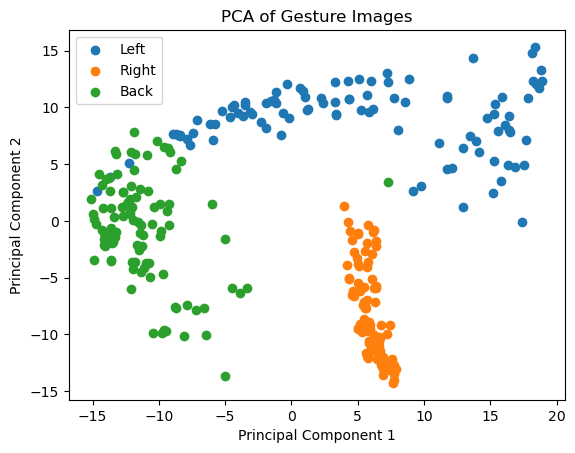

In [56]:
y = np.array([0] * len(left_images) + [1] * len(right_images) + [2] * len(back_images))


plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], label='Left')
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], label='Right')
plt.scatter(X_pca[y == 2, 0], X_pca[y == 2, 1], label='Back')
plt.legend()
plt.title('PCA of Gesture Images')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

The data appears to be adequately separated. There may be some confsuion as left and right slightly overlap, but I will go ahead and attempt to run kmeans with the reduced dimensions.

In [42]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_pca)  # X_pca is the 2D PCA-transformed data



# Get the cluster labels
cluster_labels = kmeans.labels_

C:\Users\jkost\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


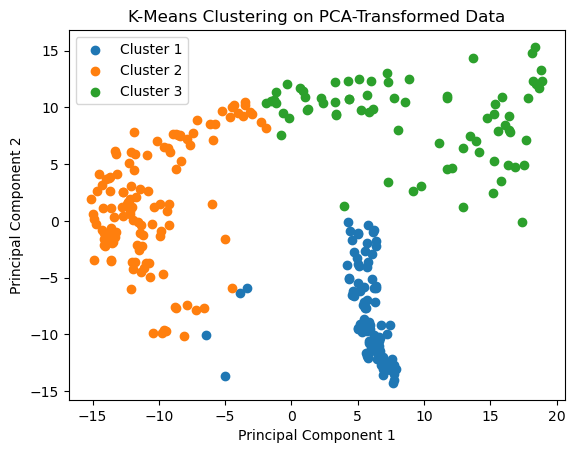

In [58]:
plt.scatter(X_pca[cluster_labels == 0, 0], X_pca[cluster_labels == 0, 1], label='Cluster 1')
plt.scatter(X_pca[cluster_labels == 1, 0], X_pca[cluster_labels == 1, 1], label='Cluster 2')
plt.scatter(X_pca[cluster_labels == 2, 0], X_pca[cluster_labels == 2, 1], label='Cluster 3')



plt.legend()
plt.title('K-Means Clustering on PCA-Transformed Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

I can see the k means was successfull, but there also seems to be some confusion between the left and back signals, as predicted.

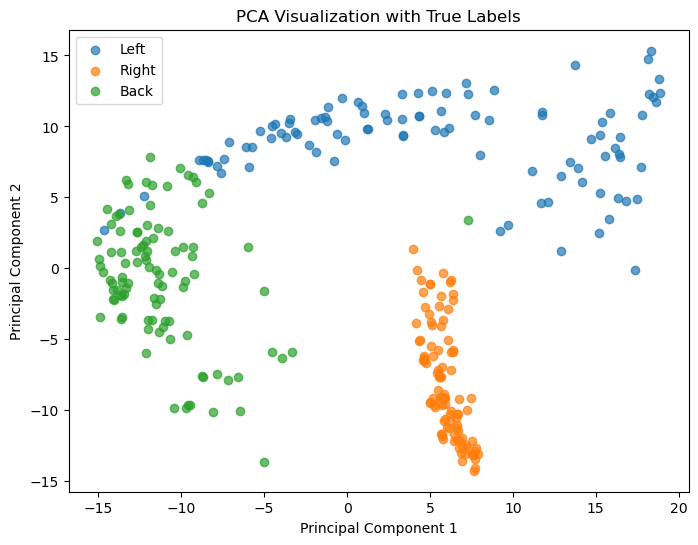

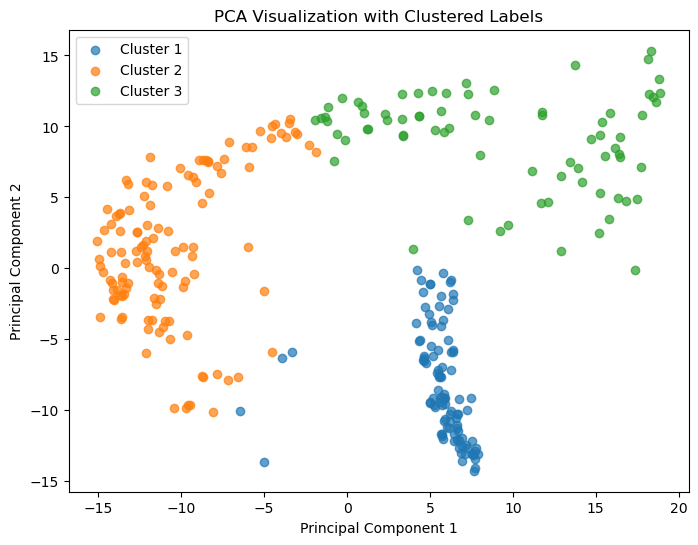

In [50]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], label='Left')
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], label='Right')
plt.scatter(X_pca[y == 2, 0], X_pca[y == 2, 1], label='Back')
plt.title('PCA Visualization with True Labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# Plot the clustered labels
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[cluster_labels == 0, 0], X_pca[cluster_labels == 0, 1], label='Cluster 1')
plt.scatter(X_pca[cluster_labels == 1, 0], X_pca[cluster_labels == 1, 1], label='Cluster 2')
plt.scatter(X_pca[cluster_labels == 2, 0], X_pca[cluster_labels == 2, 1], label='Cluster 3')
plt.title('PCA Visualization with Clustered Labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

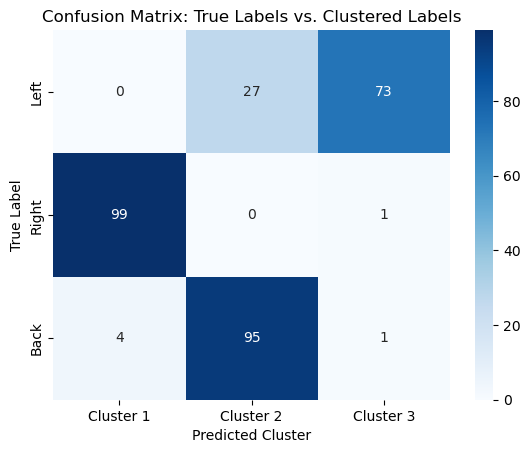

In [60]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y, cluster_labels)


sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Cluster 1', 'Cluster 2', 'Cluster 3'], yticklabels=['Left', 'Right', 'Back'])
plt.xlabel('Predicted Cluster')
plt.ylabel('True Label')
plt.title('Confusion Matrix: True Labels vs. Clustered Labels')
plt.show()


The left clusters seem to be misclassified as back. Given the time-sensitive nature of this project, I will go ahead with training on the Jetson Nano. Please refer to the GitHub for the next step in this project.